In [1]:
import kagglehub

path = kagglehub.dataset_download("urbikn/sroie-datasetv2")

print("Path to dataset files:", path)

train_img_dir = '/kaggle/input/sroie-datasetv2/SROIE2019/train/img'
train_box_dir = '/kaggle/input/sroie-datasetv2/SROIE2019/train/box'
test_img_dir = '/kaggle/input/sroie-datasetv2/SROIE2019/test/img'
test_box_dir = '/kaggle/input/sroie-datasetv2/SROIE2019/test/box'


Path to dataset files: /kaggle/input/sroie-datasetv2


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import random

def visualize_sample(img_path, box_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = []
    texts = []

    with open(box_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split(',')
        if len(parts) >= 9:
            coords = [int(p) for p in parts[:8]]
            text = ','.join(parts[8:])

            boxes.append(np.array(coords).reshape(-1, 2))
            texts.append(text)
    # Visualize
    plt.figure(figsize=(15, 15))
    plt.imshow(image)

    for i, (box, text) in enumerate(zip(boxes, texts)):
        # Vẽ bounding box
        plt.plot([box[0][0], box[1][0], box[2][0], box[3][0], box[0][0]],
                [box[0][1], box[1][1], box[2][1], box[3][1], box[0][1]], 'r-')

    plt.title('Ảnh với Bounding Boxes')
    plt.axis('off')
    plt.show()

    print("Văn bản được trích xuất:")
    for i, text in enumerate(texts):
        print(f"{i+1}. {text}")

print(f"Số lượng ảnh trong tập huấn luyện: {len(os.listdir(train_img_dir))}")
print(f"Số lượng file annotation trong tập huấn luyện: {len(os.listdir(train_box_dir))}")
print(f"Số lượng ảnh trong tập kiểm thử: {len(os.listdir(test_img_dir))}")
print(f"Số lượng file annotation trong tập kiểm thử: {len(os.listdir(test_box_dir))}")



Số lượng ảnh trong tập huấn luyện: 626
Số lượng file annotation trong tập huấn luyện: 626
Số lượng ảnh trong tập kiểm thử: 347
Số lượng file annotation trong tập kiểm thử: 347


In [3]:
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def build_vocab(box_dirs, max_chars=1000):
    """Xây dựng từ điển từ các file annotation"""
    all_chars = set()
    char_freq = Counter()

    special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
    for token in special_tokens:
        all_chars.add(token)

    all_chars.update(string.ascii_letters + string.digits + string.punctuation + ' ')

    for box_dir in box_dirs:
        for filename in os.listdir(box_dir):
            if filename.endswith('.txt'):
                filepath = os.path.join(box_dir, filename)
                with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        if len(parts) >= 9:
                            text = ','.join(parts[8:])
                            for char in text:
                                char_freq[char] += 1
                                all_chars.add(char)

    vocab = {token: idx for idx, token in enumerate(special_tokens)}

    idx = len(vocab)
    for char, _ in char_freq.most_common(max_chars - len(vocab)):
        if char not in vocab:
            vocab[char] = idx
            idx += 1

    inverse_vocab = {idx: char for char, idx in vocab.items()}

    return vocab, inverse_vocab, char_freq

def analyze_text_data(box_dirs):
    """Phân tích dữ liệu văn bản: số lượng, độ dài, phân bố..."""
    text_lengths = []
    boxes_per_image = Counter()
    total_samples = 0

    for box_dir in box_dirs:
        for filename in os.listdir(box_dir):
            if filename.endswith('.txt'):
                texts = []
                with open(os.path.join(box_dir, filename), 'r', encoding='utf-8', errors='ignore') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        if len(parts) >= 9:
                            text = ','.join(parts[8:])
                            texts.append(text)
                            text_lengths.append(len(text))
                            total_samples += 1

                boxes_per_image[len(texts)] += 1

    # Tính thống kê
    avg_text_length = sum(text_lengths) / len(text_lengths) if text_lengths else 0
    max_text_length = max(text_lengths) if text_lengths else 0

    print(f"Tổng số vùng text: {total_samples}")
    print(f"Độ dài text trung bình: {avg_text_length:.2f} ký tự")
    print(f"Độ dài text lớn nhất: {max_text_length} ký tự")

    # *** Add return statement here ***
    return max_text_length


# Xây dựng vocabulary và phân tích dữ liệu
box_dirs = [train_box_dir, test_box_dir]
vocab, inverse_vocab, char_freq = build_vocab(box_dirs)
max_text_length = analyze_text_data(box_dirs) # This will now correctly assign the returned value

print(f"Kích thước vocabulary: {len(vocab)}")

Tổng số vùng text: 52331
Độ dài text trung bình: 11.43 ký tự
Độ dài text lớn nhất: 69 ký tự
Kích thước vocabulary: 85


In [4]:
import os
import random
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, UnidentifiedImageError 

def split_train_val(img_dir, box_dir, val_ratio=0.1, seed=42):
    """Chia dữ liệu train thành tập train và validation"""
    random.seed(seed)

    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))] # Chấp nhận nhiều định dạng

    valid_files = []
    for img_file in img_files:
        base_name, _ = os.path.splitext(img_file)
        box_file = base_name + '.txt' # Linh hoạt hơn với đuôi file
        if os.path.exists(os.path.join(box_dir, box_file)):
            valid_files.append(img_file)

    random.shuffle(valid_files)

    val_size = int(len(valid_files) * val_ratio)
    train_files = valid_files[val_size:]
    val_files = valid_files[:val_size]

    print(f"Tổng số ảnh đầu vào trong img_dir: {len(img_files)}")
    print(f"Tổng số mẫu hợp lệ (có annotation): {len(valid_files)}")
    print(f"Số mẫu train: {len(train_files)}")
    print(f"Số mẫu validation: {len(val_files)}")

    return train_files, val_files

class RegionBasedOCRDataset(Dataset):
    def __init__(self, img_dir, box_dir, vocab, file_list=None,
                 transform=None, target_img_height=32, target_img_width=128,
                 max_text_len=50):
        self.img_dir = img_dir
        self.box_dir = box_dir
        self.vocab = vocab
        self.transform = transform
        self.target_img_height = target_img_height
        self.target_img_width = target_img_width
        self.max_text_len = max_text_len

        self.pad_idx = vocab['<pad>']
        self.sos_idx = vocab['<sos>']
        self.eos_idx = vocab['<eos>']
        self.unk_idx = vocab['<unk>']

        if file_list:
            self.img_files = file_list
        else:
            self.img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        self.samples = []
        valid_img_count = 0
        for img_file in self.img_files:
            img_path = os.path.join(img_dir, img_file)
            base_name, _ = os.path.splitext(img_file)
            box_file = base_name + '.txt'
            box_path = os.path.join(box_dir, box_file)

            if not os.path.exists(box_path):
                continue
            
            valid_img_count +=1
            try:
                with open(box_path, 'r', encoding='utf-8', errors='ignore') as f:
                    for i, line in enumerate(f):
                        parts = line.strip().split(',')
                        if len(parts) >= 9:
                            coords_str = parts[:8]
                            try:
                                coords = [int(p) for p in coords_str]
                            except ValueError:
                                # print(f"Cảnh báo: Tọa độ không hợp lệ trong {box_path}, dòng {i+1}: {line.strip()}")
                                continue
                            
                            text = ','.join(parts[8:])
                            if not text.strip():
                                # print(f"Cảnh báo: Vùng text rỗng trong {box_path}, dòng {i+1}")
                                continue

                            self.samples.append({
                                'img_path': img_path,
                                'coords': coords,
                                'text': text,
                                'region_id': i,
                                'img_file': img_file
                            })
            except Exception as e:
                print(f"Lỗi khi đọc file annotation {box_path}: {e}")
                continue
        
        if not self.samples:
             print(f"CẢNH BÁO: Không có mẫu nào được tải. Kiểm tra đường dẫn img_dir ({img_dir}), box_dir ({box_dir}) và file_list (nếu có).")
        print(f"Đã tải {len(self.samples)} vùng text từ {valid_img_count} ảnh (trong số {len(self.img_files)} file được liệt kê trong img_dir/file_list).")


    def __len__(self):
        return len(self.samples)

    def _order_points(self, pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def _warp_region(self, image, box_coords_list):
        box_coords = np.array(box_coords_list, dtype="float32").reshape(4, 2)
        
        if cv2.contourArea(box_coords.astype(np.int32)) < 1.0:
             return np.zeros((self.target_img_height, self.target_img_width, 3), dtype=np.uint8)

        rect = self._order_points(box_coords)
        (tl, tr, br, bl) = rect

        dst_pts = np.array([
            [0, 0],
            [self.target_img_width - 1, 0],
            [self.target_img_width - 1, self.target_img_height - 1],
            [0, self.target_img_height - 1]
        ], dtype="float32")

        try:
            M = cv2.getPerspectiveTransform(rect, dst_pts)
            warped = cv2.warpPerspective(image, M, (self.target_img_width, self.target_img_height))
        except cv2.error as e:
            try:
                x, y, w, h = cv2.boundingRect(box_coords.astype(np.int32))
                if w > 0 and h > 0:
                    crop = image[y:y+h, x:x+w].copy()
                    warped = cv2.resize(crop, (self.target_img_width, self.target_img_height))
                else:
                    warped = np.zeros((self.target_img_height, self.target_img_width, 3), dtype=np.uint8)
            except Exception as e_br:
                warped = np.zeros((self.target_img_height, self.target_img_width, 3), dtype=np.uint8)
        
        return warped
    
    def _create_dummy_data(self, img_path="dummy", region_id=-1, error_type="<ERROR_UNKNOWN>"):
        # print(f"Tạo dummy data cho {img_path}, region {region_id} do lỗi: {error_type}")
        dummy_image_tensor = torch.zeros((3, self.target_img_height, self.target_img_width), dtype=torch.float32)
        dummy_target_tensor = torch.full((self.max_text_len,), self.pad_idx, dtype=torch.long)
        dummy_target_tensor[0] = self.sos_idx
        dummy_target_tensor[1] = self.eos_idx
        return {
            'image': dummy_image_tensor,
            'target': dummy_target_tensor,
            'text': error_type,
            'img_path': img_path,
            'region_id': region_id,
            'img_file': os.path.basename(img_path) if img_path != "dummy" else "dummy"
        }

    def __getitem__(self, idx):
        if idx >= len(self.samples):
             return self._create_dummy_data(error_type="<ERROR_INDEX_OUT_OF_BOUNDS>")

        sample = self.samples[idx]
        img_path = sample['img_path']
        coords_raw = sample['coords']
        text = sample['text']
        img_file_name = sample['img_file']

        try:
            try:
                img_pil = Image.open(img_path).convert('RGB')
                img_pil.verify() 
                img_pil = Image.open(img_path).convert('RGB')
                image_np_rgb = np.array(img_pil)
            except (IOError, UnidentifiedImageError, SyntaxError, OSError) as e_pil:
                # print(f"Lỗi Pillow khi đọc {img_path}: {e_pil}. Thử với OpenCV.")
                image_bgr = cv2.imread(img_path)
                if image_bgr is None:
                    return self._create_dummy_data(img_path, sample['region_id'], "<ERROR_IMG_READ_BOTH_FAIL>")
                image_np_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        except Exception as e:
            return self._create_dummy_data(img_path, sample['region_id'], "<ERROR_IMG_LOAD_UNEXPECTED>")

        try:
            region_warped = self._warp_region(image_np_rgb, coords_raw)
            if region_warped.size == 0 or region_warped.shape[0] == 0 or region_warped.shape[1] == 0:
                # print(f"Cảnh báo: Vùng warped rỗng cho {img_path}, box {sample['region_id']}.")
                return self._create_dummy_data(img_path, sample['region_id'], "<ERROR_EMPTY_WARPED_REGION>")

            if self.transform:
                transformed = self.transform(image=region_warped)
                region_tensor = transformed['image']
            else:
                region_normalized = region_warped.astype(np.float32) / 255.0
                region_tensor = torch.from_numpy(region_normalized).permute(2, 0, 1)
        
        except Exception as e:
            # print(f"Lỗi khi warping/transforming ảnh {img_path}, box {sample['region_id']}: {e}")
            return self._create_dummy_data(img_path, sample['region_id'], "<ERROR_TRANSFORM>")

        target_tensor = torch.full((self.max_text_len,), self.pad_idx, dtype=torch.long)
        target_tensor[0] = self.sos_idx
        encoded_text = [self.vocab.get(char, self.unk_idx) for char in text]
        effective_text_len = min(len(encoded_text), self.max_text_len - 2)

        if effective_text_len > 0:
            target_tensor[1 : 1 + effective_text_len] = torch.tensor(encoded_text[:effective_text_len], dtype=torch.long)
        
        eos_pos = 1 + effective_text_len
        if eos_pos < self.max_text_len:
            target_tensor[eos_pos] = self.eos_idx
        else:
            target_tensor[self.max_text_len -1] = self.eos_idx

        return {
            'image': region_tensor,
            'target': target_tensor,
            'text': text,
            'img_path': img_path,
            'region_id': sample['region_id'],
            'img_file': img_file_name
        }

# Chia tập train thành train và validation
if train_img_dir and os.path.exists(train_img_dir) and train_box_dir and os.path.exists(train_box_dir):
    train_files, val_files = split_train_val(train_img_dir, train_box_dir, val_ratio=0.1)
else:
    print("CẢNH BÁO: Đường dẫn train_img_dir hoặc train_box_dir không hợp lệ. Không thể chia train/val.")
    train_files, val_files = [], []


# Tạo transforms
TARGET_IMG_HEIGHT = 32
TARGET_IMG_WIDTH = 128

train_transform = A.Compose([
    # A.Resize đã được thực hiện trong _warp_region
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ], p=0.4), # Tăng p một chút
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.5), # Giảm blur_limit một chút
        A.MotionBlur(blur_limit=(3, 5), p=0.5),   # Giảm blur_limit một chút
    ], p=0.3), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    # A.Resize đã được thực hiện trong _warp_region
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Chuẩn bị datasets
# max_text_length nên là giá trị phân tích được + 2 (cho SOS/EOS)
# Giả sử max_text_length là 69 như cell trước, vậy EFFECTIVE_MAX_TEXT_LEN = 71
EFFECTIVE_MAX_TEXT_LEN = max_text_length + 2 

if train_files: # Chỉ tạo dataset nếu có file
    train_dataset = RegionBasedOCRDataset(
        img_dir=train_img_dir,
        box_dir=train_box_dir,
        vocab=vocab,
        file_list=train_files,
        transform=train_transform,
        target_img_height=TARGET_IMG_HEIGHT,
        target_img_width=TARGET_IMG_WIDTH,
        max_text_len=EFFECTIVE_MAX_TEXT_LEN
    )
else:
    train_dataset = None
    print("Không tạo train_dataset do không có train_files.")

if val_files:
    val_dataset = RegionBasedOCRDataset(
        img_dir=train_img_dir, # Vẫn dùng img_dir và box_dir của tập train cho validation
        box_dir=train_box_dir,
        vocab=vocab,
        file_list=val_files,
        transform=val_transform,
        target_img_height=TARGET_IMG_HEIGHT,
        target_img_width=TARGET_IMG_WIDTH,
        max_text_len=EFFECTIVE_MAX_TEXT_LEN
    )
else:
    val_dataset = None
    print("Không tạo val_dataset do không có val_files.")

if test_img_dir and os.path.exists(test_img_dir) and test_box_dir and os.path.exists(test_box_dir):
    test_dataset = RegionBasedOCRDataset(
        img_dir=test_img_dir,
        box_dir=test_box_dir,
        vocab=vocab,
        transform=val_transform,
        target_img_height=TARGET_IMG_HEIGHT,
        target_img_width=TARGET_IMG_WIDTH,
        max_text_len=EFFECTIVE_MAX_TEXT_LEN
    )
else:
    test_dataset = None
    print("CẢNH BÁO: Đường dẫn test_img_dir hoặc test_box_dir không hợp lệ. Không tạo test_dataset.")


# Tạo DataLoaders
batch_size = 64 # Bạn có thể thử giảm nếu gặp lỗi OOM (Out of Memory)

# Chỉ tạo DataLoader nếu dataset tương ứng được tạo
if train_dataset:
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0, # Trên Kaggle/Colab, 2 thường là đủ
        pin_memory=torch.cuda.is_available(), # True nếu có GPU
        # Thêm collate_fn nếu cần xử lý batch không đồng đều (thường không cần với padding)
    )
    print(f"\nSố batch trong train_loader: {len(train_loader)}")
else:
    train_loader = None
    print("\nKhông tạo train_loader.")


if val_dataset:
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )
    print(f"Số batch trong val_loader: {len(val_loader)}")
else:
    val_loader = None
    print("Không tạo val_loader.")


if test_dataset:
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )
    print(f"Số batch trong test_loader: {len(test_loader)}")
else:
    test_loader = None
    print("Không tạo test_loader.")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Tổng số ảnh đầu vào trong img_dir: 626
Tổng số mẫu hợp lệ (có annotation): 626
Số mẫu train: 564
Số mẫu validation: 62
Đã tải 30560 vùng text từ 564 ảnh (trong số 564 file được liệt kê trong img_dir/file_list).
Đã tải 3066 vùng text từ 62 ảnh (trong số 62 file được liệt kê trong img_dir/file_list).
Đã tải 18705 vùng text từ 347 ảnh (trong số 347 file được liệt kê trong img_dir/file_list).

Số batch trong train_loader: 478
Số batch trong val_loader: 48
Số batch trong test_loader: 293


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CNNTransformerOCR(nn.Module):
    def __init__(self, vocab_size, hidden_dim=128, nhead=4, num_decoder_layers=3, dropout=0.2):
        super(CNNTransformerOCR, self).__init__()

        # CNN backbone - ResNet18 hoặc nhẹ hơn
        mobilenet = models.mobilenet_v3_small(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(mobilenet.children())[:-2])
        self.feature_proj = nn.Sequential(
            nn.Conv2d(576, hidden_dim, kernel_size=1),  # MobileNetV3-Small có 576 kênh
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Text embedding
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(hidden_dim)

        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=1024,
            dropout=dropout,
            activation="gelu"
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers,
            norm=nn.LayerNorm(hidden_dim)
        )

        # Output projection
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

        # Special token indices
        self.sos_idx = vocab['<sos>']
        self.eos_idx = vocab['<eos>']
        self.pad_idx = vocab['<pad>']

    def forward(self, img, tgt, tgt_mask=None, tgt_padding_mask=None):
        """
        Forward pass

        Args:
            img: [B, C, H, W]
            tgt: [B, T]
            tgt_mask: [T, T]
            tgt_padding_mask: [B, T]

        Returns:
            logits: [B, T, vocab_size]
        """
        # CNN feature extraction
        features = self.cnn_backbone(img)  # [B, 512, H/32, W/32]
        features = self.feature_proj(features)  # [B, hidden_dim, H/32, W/32]

        # Reshape feature map to sequence
        h, w = features.size(2), features.size(3)
        features = features.permute(0, 2, 3, 1).flatten(1, 2)  # [B, H*W, hidden_dim]
        features = features.permute(1, 0, 2)  # [H*W, B, hidden_dim]

        # Target embedding with positional encoding
        tgt_embedded = self.embedding(tgt)  # [B, tgt_len, hidden_dim]
        tgt_embedded = self.positional_encoding(tgt_embedded)  # [B, tgt_len, hidden_dim]
        tgt_embedded = tgt_embedded.permute(1, 0, 2)  # [tgt_len, B, hidden_dim]

        # Transformer decoder
        output = self.transformer_decoder(
            tgt_embedded,
            features,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )  # [tgt_len, B, hidden_dim]

        # Project to vocabulary size
        output = output.permute(1, 0, 2)  # [B, tgt_len, hidden_dim]
        logits = self.fc_out(output)  # [B, tgt_len, vocab_size]

        return logits

    def generate_square_subsequent_mask(self, sz):
        """Generate square mask for transformer"""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def create_padding_mask(self, tgt):
        """Create padding mask for transformer (float type)"""
        padding_mask = (tgt == self.pad_idx) # [B, T] - boolean mask
        # Convert boolean mask to float mask
        float_mask = torch.zeros_like(padding_mask, dtype=torch.float).to(padding_mask.device)
        float_mask.masked_fill_(padding_mask, float('-inf'))
        return float_mask # [B, T] - float mask

    def generate(self, img, max_length=100, temperature=1.0):
        """
        Generate text from image using greedy decoding

        Args:
            img: [B, C, H, W]
            max_length: maximum sequence length to generate

        Returns:
            generated_ids: [B, max_length]
        """
        batch_size = img.size(0)
        device = img.device

        # CNN feature extraction
        features = self.cnn_backbone(img)
        features = self.feature_proj(features)

        # Reshape feature map to sequence
        h, w = features.size(2), features.size(3)
        features = features.permute(0, 2, 3, 1).flatten(1, 2)
        features = features.permute(1, 0, 2)

        # Khởi tạo output với token <sos>
        current_ids = torch.ones(batch_size, 1).fill_(self.sos_idx).long().to(device)

        # Lặp cho đến khi đạt max_length hoặc gặp <eos> token
        for i in range(max_length - 1):
            # Tạo mask cho transformer
            tgt_mask = self.generate_square_subsequent_mask(current_ids.size(1)).to(device)
            tgt_padding_mask = self.create_padding_mask(current_ids)

            # Target embedding
            tgt_embedded = self.embedding(current_ids)
            tgt_embedded = self.positional_encoding(tgt_embedded)
            tgt_embedded = tgt_embedded.permute(1, 0, 2)

            # Transformer decoder
            output = self.transformer_decoder(
                tgt_embedded,
                features,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask
            )

            # Lấy dự đoán cho token tiếp theo
            output = output.permute(1, 0, 2)
            logits = self.fc_out(output[:, -1, :])

            # Áp dụng temperature sampling
            if temperature != 1.0:
                logits = logits / temperature

            # Lấy token có xác suất cao nhất
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

            # Thêm token mới vào chuỗi
            current_ids = torch.cat([current_ids, next_token], dim=1)

            # Dừng nếu tất cả các chuỗi đều gặp <eos>
            if ((next_token == self.eos_idx).sum() == batch_size).item():
                break

        return current_ids

# Khởi tạo mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNNTransformerOCR(
    vocab_size=len(vocab),
    hidden_dim=128,
    nhead=4,
    num_decoder_layers=3,
    dropout=0.2
).to(device)

# Tính tổng số tham số
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Tổng số tham số: {total_params:,}")
print(f"Số tham số cần huấn luyện: {trainable_params:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


Using device: cuda


100%|██████████| 9.83M/9.83M [00:00<00:00, 65.3MB/s]


Tổng số tham số: 2,211,701
Số tham số cần huấn luyện: 2,211,701


In [6]:
!pip install python-Levenshtein
import time
import torch.optim as optim
from tqdm.auto import tqdm
import Levenshtein

# Hàm tính Character Error Rate (CER)
def calculate_cer(pred_texts, gt_texts):
    """Tính Character Error Rate"""
    total_cer = 0
    total_chars = 0

    for pred, gt in zip(pred_texts, gt_texts):
        distance = Levenshtein.distance(pred, gt)
        total_cer += distance
        total_chars += len(gt)

    return total_cer / max(total_chars, 1)

# Hàm tính Word Error Rate (WER)
def calculate_wer(pred_texts, gt_texts):
    """Tính Word Error Rate"""
    total_wer = 0
    total_words = 0

    for pred, gt in zip(pred_texts, gt_texts):
        pred_words = pred.split()
        gt_words = gt.split()

        distance = Levenshtein.distance(pred_words, gt_words)
        total_wer += distance
        total_words += len(gt_words)

    return total_wer / max(total_words, 1)

# Hàm giải mã text từ indices
def decode_text(indices, inverse_vocab, remove_special=True):
    """Decode indices thành text"""
    text = ""
    for idx in indices:
        if idx == vocab['<eos>']:
            break
        if remove_special and idx in [vocab['<pad>'], vocab['<sos>']]:
            continue
        text += inverse_vocab.get(idx.item(), '')
    return text

# Hàm huấn luyện cho một epoch
def train_one_epoch(model, dataloader, optimizer, criterion, device, clip_grad=5.0):
    model.train()
    epoch_loss = 0

    with tqdm(dataloader, desc="Training") as progress_bar:
        for batch in progress_bar:
            # Chuẩn bị dữ liệu
            images = batch['image'].to(device)
            targets = batch['target'].to(device)

            # Teacher forcing: sử dụng target để tạo input
            tgt_input = targets[:, :-1]
            tgt_output = targets[:, 1:]

            # Tạo masks cho transformer
            tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            tgt_padding_mask = model.create_padding_mask(tgt_input)

            # Forward pass
            optimizer.zero_grad()

            outputs = model(images, tgt_input, tgt_mask, tgt_padding_mask)

            # Tính loss
            loss = criterion(
                outputs.reshape(-1, outputs.shape[-1]),
                tgt_output.reshape(-1)
            )

            # Backward và optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()

            # Cập nhật thống kê
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    return epoch_loss / len(dataloader)
# Hàm đánh giá mô hình
def evaluate(model, dataloader, criterion, device, inverse_vocab):
    model.eval()
    val_loss = 0
    all_pred_texts = []
    all_gt_texts = []
    correct_predictions = 0
    total_regions = 0

    with torch.no_grad():
        with tqdm(dataloader, desc="Evaluating") as progress_bar:
            for batch in progress_bar:
                # Chuẩn bị dữ liệu
                images = batch['image'].to(device)
                targets = batch['target'].to(device)
                gt_texts = batch['text']

                # Forward pass cho loss calculation (teacher forcing)
                tgt_input = targets[:, :-1]
                tgt_output = targets[:, 1:]

                # Ensure masks are generated correctly for the target sequence length
                tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
                tgt_padding_mask = model.create_padding_mask(tgt_input)

                outputs = model(images, tgt_input, tgt_mask, tgt_padding_mask)

                # Tính loss
                # Reshape outputs and targets to (batch_size * sequence_length, vocab_size) and (batch_size * sequence_length) respectively
                loss = criterion(
                    outputs.reshape(-1, outputs.shape[-1]),
                    tgt_output.reshape(-1)
                )
                val_loss += loss.item()

                predictions = model.generate(images, max_length=targets.size(1)) # Use target length as max_length for generation during evaluation

                # Decode dự đoán và so sánh với ground truth
                for i in range(len(predictions)):
                    pred_text = decode_text(predictions[i], inverse_vocab)
                    gt_text = gt_texts[i]

                    all_pred_texts.append(pred_text)
                    all_gt_texts.append(gt_text)

                    # Tính accuracy (exact match)
                    if pred_text == gt_text:
                        correct_predictions += 1
                    total_regions += 1

                progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    # Tính metrics
    avg_loss = val_loss / len(dataloader)
    cer = calculate_cer(all_pred_texts, all_gt_texts)
    wer = calculate_wer(all_pred_texts, all_gt_texts)
    accuracy = correct_predictions / total_regions if total_regions > 0 else 0

    return avg_loss, cer, wer, accuracy, all_pred_texts, all_gt_texts

# Hàm huấn luyện mô hình
def train_model(model, train_loader, val_loader, optimizer, criterion,
                scheduler, device, epochs=30, save_dir='models'):
    best_cer = float('inf')
    train_losses = []
    val_losses = []
    cers = []
    wers = []
    accuracies = []

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        # Validate
        val_loss, cer, wer, accuracy, pred_texts, gt_texts = evaluate(
            model, val_loader, criterion, device, inverse_vocab
        )
        val_losses.append(val_loss)
        cers.append(cer)
        wers.append(wer)
        accuracies.append(accuracy)

        # Cập nhật learning rate
        scheduler.step(val_loss)

        # In kết quả
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, CER: {cer:.4f}, WER: {wer:.4f}")

        # Lưu model tốt nhất
        if cer < best_cer:
            best_cer = cer
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'cer': cer,
                'wer': wer,
                'accuracy': accuracy,
                'vocab': vocab,
                'inverse_vocab': inverse_vocab
            }, f"{save_dir}/best_model.pth")
            print(f"New best model saved with CER: {cer:.4f}")

            # Lưu một số ví dụ dự đoán
            with open(f"{save_dir}/best_predictions.txt", 'w', encoding='utf-8') as f:
                for i, (pred, gt) in enumerate(zip(pred_texts[:20], gt_texts[:20])):
                    f.write(f"Example {i+1}\n")
                    f.write(f"Pred: {pred}\n")
                    f.write(f"GT  : {gt}\n")
                    f.write(f"CER : {calculate_cer([pred], [gt]):.4f}\n")
                    f.write("-" * 50 + "\n")

        # Lưu checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'cer': cer,
            'wer': wer,
            'accuracy': accuracy
        }, f"{save_dir}/checkpoint_epoch_{epoch}.pth")

    print("Training completed!")
    return train_losses, val_losses, cers, wers, accuracy

criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

print("Đã thiết lập criterion, optimizer và scheduler.")
print("Sẵn sàng để bắt đầu huấn luyện!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.1 MB/s eta 0:00:00:00:01
Đã thiết lập criterion, optimizer và scheduler.
Sẵn sàng để bắt đầu huấn luyện!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# Thiết lập số epochs và thư mục lưu model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_epochs = 10
save_dir = '/kaggle/working/ocr_models'

# Huấn luyện mô hình
train_losses, val_losses, cers, wers, accuracy = train_model(
    model, train_loader, val_loader, optimizer, criterion,
    scheduler, device, epochs=num_epochs, save_dir=save_dir
)

print(f"Kết quả cuối cùng:")
print(f"Train Loss: {train_losses[-1]:.4f}")
print(f"Val Loss: {val_losses[-1]:.4f}")
print(f"CER: {cers[-1]:.4f}")
print(f"WER: {wers[-1]:.4f}")

Using device: cuda

Epoch 1/10


Training:   0%|          | 0/478 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Train Loss: 2.2404
Val Loss: 1.5286, CER: 0.7692, WER: 0.9327
New best model saved with CER: 0.7692

Epoch 2/10


Training:   0%|          | 0/478 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Train Loss: 1.4740
Val Loss: 1.1430, CER: 0.6151, WER: 0.7856
New best model saved with CER: 0.6151

Epoch 3/10


Training:   0%|          | 0/478 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Train Loss: 1.1925
Val Loss: 0.9465, CER: 0.5032, WER: 0.6506
New best model saved with CER: 0.5032

Epoch 4/10


Training:   0%|          | 0/478 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
save_dir = '/kaggle/working/ocr_models'
os.makedirs(save_dir, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def resume_training(checkpoint_path, num_epochs=20):
    """Tiếp tục huấn luyện từ checkpoint đã lưu"""
    # Tải checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Tạo model mới
    resumed_model = CNNTransformerOCR(
        vocab_size=len(vocab),
        hidden_dim=128,
        nhead=4,
        num_decoder_layers=3,
        dropout=0.2
    ).to(device)

    # Tải trạng thái model
    resumed_model.load_state_dict(checkpoint['model_state_dict'])

    # Tạo optimizer mới và tải trạng thái
    resumed_optimizer = optim.AdamW(resumed_model.parameters(), lr=5e-4, weight_decay=1e-5)
    resumed_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Tạo scheduler mới và tải trạng thái (nếu có)
    resumed_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        resumed_optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    if 'scheduler_state_dict' in checkpoint:
        resumed_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Lấy số epoch đã train và các giá trị metrics
    start_epoch = checkpoint['epoch'] + 1
    print(f"Tiếp tục huấn luyện từ epoch {start_epoch}")

    # Khôi phục các lists tracking
    train_losses = []
    val_losses = []
    cers = []
    wers = []
    accuracies = []
    # Nếu có lưu history thì khôi phục
    if 'train_losses' in checkpoint:
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        cers = checkpoint['cers']
        wers = checkpoint['wers']
    # Nếu không, thêm giá trị của checkpoint hiện tại
    else:
        if 'train_loss' in checkpoint:
            train_losses.append(checkpoint['train_loss'])
        if 'val_loss' in checkpoint:
            val_losses.append(checkpoint['val_loss'])
        if 'cer' in checkpoint:
            cers.append(checkpoint['cer'])
        if 'wer' in checkpoint:
            wers.append(checkpoint['wer'])

    # Tiếp tục huấn luyện
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # Train
        train_loss = train_one_epoch(resumed_model, train_loader, resumed_optimizer, criterion, device)
        train_losses.append(train_loss)

        # Validate
        val_loss, cer, wer, accuracy, pred_texts, gt_texts = evaluate(
            resumed_model, val_loader, criterion, device, inverse_vocab
        )
        val_losses.append(val_loss)
        cers.append(cer)
        wers.append(wer)
        accuracies.append(accuracy)
        # Cập nhật learning rate
        resumed_scheduler.step(val_loss)

        # In kết quả
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, CER: {cer:.4f}, WER: {wer:.4f}")

        # Lưu model tốt nhất
        if cer <= min(cers):
            torch.save({
                'epoch': epoch,
                'model_state_dict': resumed_model.state_dict(),
                'optimizer_state_dict': resumed_optimizer.state_dict(),
                'scheduler_state_dict': resumed_scheduler.state_dict(),
                'val_loss': val_loss,
                'cer': cer,
                'wer': wer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'cers': cers,
                'wers': wers,
                'accuracy': accuracy,
                'vocab': vocab,
                'inverse_vocab': inverse_vocab
            }, f"{save_dir}/best_model.pth")
            print(f"New best model saved with CER: {cer:.4f}")

        # Lưu checkpoint hiện tại
        torch.save({
            'epoch': epoch,
            'model_state_dict': resumed_model.state_dict(),
            'optimizer_state_dict': resumed_optimizer.state_dict(),
            'scheduler_state_dict': resumed_scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'cer': cer,
            'wer': wer,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'cers': cers,
            'wers': wers,
            'accuracy': accuracy,
        }, f"{save_dir}/checkpoint_epoch_{epoch}.pth")

    print("Training completed!")
    return resumed_model


checkpoint_path = "/kaggle/input/epoch_train_sroie/pytorch/default/1/checkpoint_epoch_5 (1).pth"
resumed_model = resume_training(checkpoint_path, num_epochs=20)

Using device: cuda
Tiếp tục huấn luyện từ epoch 6

Epoch 6/20


Training:   0%|          | 0/478 [00:00<?, ?it/s]

In [18]:
best_model_path = "/kaggle/working/ocr_models/best_model.pth"
if os.path.exists(best_model_path):
    print(f"Tải mô hình tốt nhất từ {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    # Tạo một instance mới của mô hình để tải state_dict vào
    model_to_evaluate = CNNTransformerOCR(
        vocab_size=len(vocab),
        hidden_dim=256,
        nhead=8,
        num_decoder_layers=6,
        dropout=0.1 # Đảm bảo dropout khớp
    ).to(device)
    model_to_evaluate.load_state_dict(checkpoint['model_state_dict'])
    print("Đã tải mô hình tốt nhất.")
else:
    print(f"Không tìm thấy mô hình tốt nhất tại {best_model_path}. Sử dụng mô hình hiện tại trong bộ nhớ.")
    model_to_evaluate = model # Hoặc resumed_model

# Thực hiện đánh giá trên tập test
test_loss, test_cer, test_wer, test_accuracy, test_pred_texts, test_gt_texts = evaluate(
# ========================================
    model_to_evaluate, test_loader, criterion, device, inverse_vocab
)

# In kết quả đánh giá trên tập test
print(f"\nKết quả đánh giá trên tập Test:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test CER: {test_cer:.4f}")
print(f"Test WER: {test_wer:.4f}")
# === THÊM DÒNG NÀY ĐỂ IN ACCURACY ===
print(f"Test Accuracy: {test_accuracy:.4f}")
# ====================================

# Optionally, print some test predictions
print("\nMột số ví dụ dự đoán trên tập Test:")
for i in range(min(10, len(test_pred_texts))): # In 10 ví dụ đầu tiên
    print(f"Example {i+1}:")
    print(f"  Pred: {test_pred_texts[i]}")
    print(f"  GT  : {test_gt_texts[i]}")
    print(f"  CER : {calculate_cer([test_pred_texts[i]], [test_gt_texts[i]]):.4f}")
    print("-" * 20)

Tải mô hình tốt nhất từ /kaggle/working/ocr_models/best_model.pth
Đã tải mô hình tốt nhất.


Evaluating:   0%|          | 0/293 [00:00<?, ?it/s]


Kết quả đánh giá trên tập Test:
Test Loss: 0.4463
Test CER: 0.1899
Test WER: 0.3076
Test Accuracy: 0.7342

Một số ví dụ dự đoán trên tập Test:
Example 1:
  Pred: 06066000018800001815
  GT  : HENG KEE DELIGHTS BAK KUT TEH.
  CER : 1.0000
--------------------
Example 2:
  Pred: NO.12 JALAN SS25/6,
  GT  : NO31 , JALAN 3/62A ,
  CER : 0.4500
--------------------
Example 3:
  Pred: BANDAR BUKITA JAYA,
  GT  : BANDAR MENJALARA
  CER : 0.5625
--------------------
Example 4:
  Pred: EXCHANGE 5500 KUALA LUMPUR
  GT  : KEPONG. 52100 KUALA LUMPUR
  CER : 0.3077
--------------------
Example 5:
  Pred: GST NO: 000310431168
  GT  : GST NO : 000403890176
  CER : 0.4286
--------------------
Example 6:
  Pred: BE : 016-5586558
  GT  : H/P : 016-6555553
  CER : 0.4118
--------------------
Example 7:
  Pred: TAX INVOICE
  GT  : TAX INVOICE
  CER : 0.0000
--------------------
Example 8:
  Pred: : 10511530
  GT  : : TB011530
  CER : 0.3000
--------------------
Example 9:
  Pred: VALUE S/MART AMT
  GT  : 

Tải mô hình tốt nhất từ /kaggle/working/ocr_models/best_model.pth để dự đoán.
Đã tải mô hình tốt nhất và đặt ở chế độ eval.

Đang xử lý ảnh: X51006389894.jpg


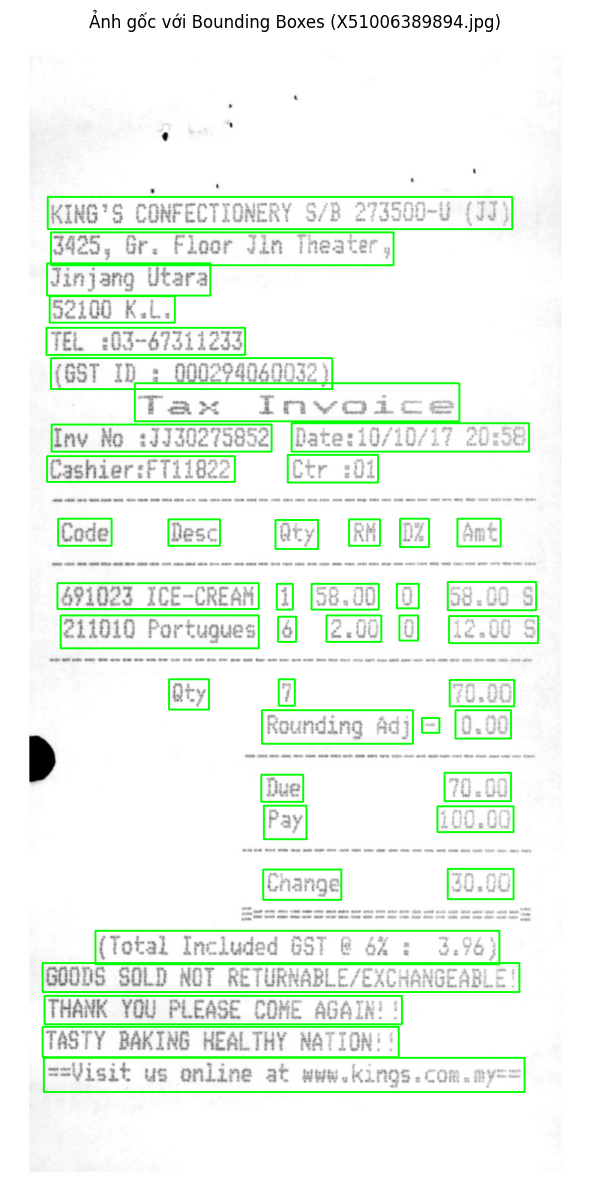


Kết quả dự đoán cho từng vùng text:
Vùng 1:
  GT  : KING'S CONFECTIONERY S/B 273500-U (JJ)
  Pred: RAMT SUNWAY,
  CER : 0.8947
--------------------
Vùng 2:
  GT  : 3425, GR. FLOOR JLN THEATER ,
  Pred: 340ML TAPE (SRINGL.
  CER : 0.8276
--------------------
Vùng 3:
  GT  : JINJANG UTARA
  Pred: TAX INVOICE MUST
  CER : 1.0769
--------------------
Vùng 4:
  GT  : 52100 K.L.
  Pred: 501100 KUALA LUMPUR
  CER : 1.2000
--------------------
Vùng 5:
  GT  : TEL :03-67311233
  Pred: TAX RETURNABLE
  CER : 0.8750
--------------------
Vùng 6:
  GT  : (GST ID : 000294060032)
  Pred: (ROUNDING)
  CER : 0.8696
--------------------
Vùng 7:
  GT  : TAX INVOICE
  Pred: -
  CER : 1.0000
--------------------
Vùng 8:
  GT  : 0.00
  Pred: 0.00
  CER : 0.0000
--------------------
Vùng 9:
  GT  : INV NO :JJ30275852
  Pred: TAX INVOICE
  CER : 0.9444
--------------------
Vùng 10:
  GT  : DATE:10/10/17 20:58
  Pred: TAX ROUNDER
  CER : 0.9474
--------------------
Vùng 11:
  GT  : CASHIER:FT11822
  Pred: CLO

In [19]:
from pathlib import Path

# Load the best model for prediction
best_model_path = "/kaggle/working/ocr_models/best_model.pth"
if os.path.exists(best_model_path):
    print(f"Tải mô hình tốt nhất từ {best_model_path} để dự đoán.")
    checkpoint = torch.load(best_model_path, map_location=device)
    prediction_model = CNNTransformerOCR(
        vocab_size=len(vocab),
        hidden_dim=256,
        nhead=8,
        num_decoder_layers=6,
        dropout=0.1 # Ensure dropout matches training, or use prediction-specific value if needed
    ).to(device)
    prediction_model.load_state_dict(checkpoint['model_state_dict'])
    prediction_model.eval() # Set model to evaluation mode
    print("Đã tải mô hình tốt nhất và đặt ở chế độ eval.")
else:
    print(f"Không tìm thấy mô hình tốt nhất tại {best_model_path}. Vui lòng huấn luyện hoặc tải mô hình trước.")
    prediction_model = None # Set to None if model not found

if prediction_model is not None:
    # Chọn một ảnh ngẫu nhiên từ tập test
    test_imgs = os.listdir(test_img_dir)
    if test_imgs:
        img_name = random.choice(test_imgs)
        img_path = os.path.join(test_img_dir, img_name)
        box_path = os.path.join(test_box_dir, img_name.replace('.jpg', '.txt'))

        if os.path.exists(box_path):
            print(f"\nĐang xử lý ảnh: {img_name}")

            # Đọc ảnh gốc
            image = cv2.imread(img_path)
            if image is None:
                print(f"Không thể đọc ảnh: {img_path}")
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                display_image = image.copy() # Make a copy for drawing

                # Đọc bounding box và ground truth text
                boxes = []
                gt_texts = []
                try:
                    with open(box_path, 'r', encoding='utf-8', errors='ignore') as f:
                        lines = f.readlines()
                    for line in lines:
                        parts = line.strip().split(',')
                        if len(parts) >= 9:
                            coords = [int(p) for p in parts[:8]]
                            text = ','.join(parts[8:])
                            boxes.append(np.array(coords).reshape(-1, 2))
                            gt_texts.append(text)
                except Exception as e:
                    print(f"Lỗi khi đọc file annotation {box_path}: {e}")
                    boxes = [] # Ensure boxes is empty if error occurs

                predicted_texts = []

                if boxes:
                    # Xử lý từng vùng text và dự đoán
                    for i, box_coords in enumerate(boxes):
                        # Tính bounding rectangle
                        x, y, w, h = cv2.boundingRect(box_coords)

                        # Thêm padding
                        padding = 3
                        x = max(0, x - padding)
                        y = max(0, y - padding)
                        w = min(image.shape[1] - x, w + 2*padding)
                        h = min(image.shape[0] - y, h + 2*padding)

                        # Crop vùng ảnh
                        region = image[y:y+h, x:x+w].copy()

                        if region.size > 0:
                            # Áp dụng transform (chỉ resize và normalize)
                            # Sử dụng transform giống như validation/test set
                            region_transformed = val_transform(image=region)['image']
                            region_transformed = region_transformed.unsqueeze(0).to(device) # Add batch dimension

                            # Dự đoán text
                            with torch.no_grad():
                                predictions = prediction_model.generate(region_transformed, max_length=max_text_length + 2)
                                predicted_text = decode_text(predictions[0], inverse_vocab, remove_special=True) # Decode the first sample in batch

                            predicted_texts.append(predicted_text)

                            # Vẽ bounding box lên ảnh hiển thị
                            # Vẽ hình chữ nhật đơn giản dựa trên boundingRect để dễ hơn
                            cv2.rectangle(display_image, (x, y), (x+w, y+h), (0, 255, 0), 2) # Green color
                            # Optionally add a text label on the image (can be crowded)
                            # cv2.putText(display_image, predicted_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

                        else:
                            predicted_texts.append("Error: Empty region")
                            print(f"Warning: Empty region for box {i} in {img_name}")


                    # Hiển thị ảnh với bounding box
                    plt.figure(figsize=(15, 15))
                    plt.imshow(display_image)
                    plt.title(f'Ảnh gốc với Bounding Boxes ({img_name})')
                    plt.axis('off')
                    plt.show()

                    # In ra dự đoán text cho từng vùng
                    print("\nKết quả dự đoán cho từng vùng text:")
                    for i, (gt, pred) in enumerate(zip(gt_texts, predicted_texts)):
                         # Tính CER cho từng cặp
                        cer_single = calculate_cer([pred], [gt])
                        print(f"Vùng {i+1}:")
                        print(f"  GT  : {gt}")
                        print(f"  Pred: {pred}")
                        print(f"  CER : {cer_single:.4f}")
                        print("-" * 20)

                else:
                    print("Không tìm thấy bounding box trong file annotation.")

        else:
            print(f"Không tìm thấy file annotation cho {img_name}")
    else:
        print("Không tìm thấy ảnh trong thư mục test.")